In [1]:
# Libraries import

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from utilities import create_main_dataframe

In [2]:
# Functions definition

def fit_data(x_in, y_in): # Function for channel/sensor calibration using Linear Regression
    
    model = LinearRegression()
    model.fit(x_in, y_in)

    y_pred = model.predict(x_in)

    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)

    res = {"y_pred": y_pred,
         "m_inter": model.intercept_[0],
         "m_coef": model.coef_[0][0],
         "MAE": mae,
         "MSE": mse,
         "RMSE": rmse,
         "R2": r2
         }
    return res

In [3]:
# Load and prepare the data

task2_path = ".\\task_2_sensor_calibration"
main_frame = create_main_dataframe(task2_path, measurement_type="calibration")
main_frame["OxygenC"] = main_frame["MFC2"] / (main_frame["MFC1"] + main_frame["MFC2"]) * 20.9 # Compute the Oxygen Concentration
current_data = main_frame[main_frame["DataType"] == " Current"].copy()
current_data["Current"] = current_data["Current"] * 1e3 # Current in the files is given in uA. To convert to nA values are multiplied by 1e3

In [4]:
# Preparation for upcoming plots 

sensors = current_data["ChNum"].unique()
categories = current_data["ConcNum"].unique()
num_categories = len(categories)
colormap = plt.colormaps['tab10'].colors
category_colors = {category: colormap[j] for j, category in enumerate(categories)}

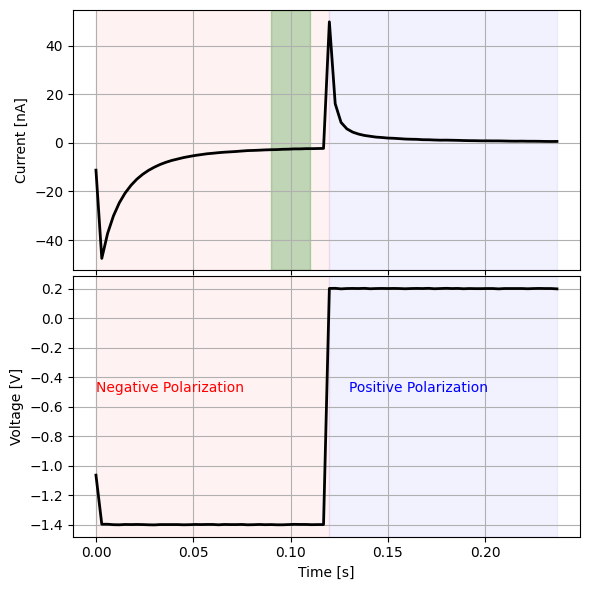

In [5]:
# Plot individual I(t) and V(t) graphs for definitions 

channel_number = "F22"
measurement_number = 0
sweep_number = 0 
concentration_number = 0 

one_sensor_one_m = current_data[
    (current_data["ChNum"] == channel_number)&
    (current_data["MeasureNum"] == measurement_number)&
    (current_data["SweepNum"] == sweep_number)&
    (current_data["ConcNum"] == concentration_number)
].copy()

t_1 = 0.09
t_2 = 0.11
t_start = 0
t_mid = 0.12
t_end = one_sensor_one_m["Time"].iloc[-1]

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 6), sharex=True)

ax[0].axvspan(t_start, t_mid, color='red', alpha=0.05)
ax[0].axvspan(t_mid, t_end, color='blue', alpha=0.05)
ax[1].axvspan(t_start, t_mid, color='red', alpha=0.05)
ax[1].axvspan(t_mid, t_end, color='blue', alpha=0.05)
ax[0].axvspan(t_1, t_2, color='green', alpha=0.25)


ax[0].plot(one_sensor_one_m["Time"], one_sensor_one_m["Current"], linewidth=2, c="black")
ax[1].plot(one_sensor_one_m["Time"], one_sensor_one_m["Voltage"], linewidth=2, c="black")

ax[1].set_xlabel("Time [s]")
ax[0].set_ylabel("Current [nA]")
ax[1].set_ylabel("Voltage [V]")

ax[1].text(0, -0.5, "Negative Polarization", color="red")
ax[1].text(0.13, -0.5, "Positive Polarization", color="blue")

ax[0].grid(True)
ax[1].grid(True)

fig.tight_layout(h_pad=0.1)

TASK 1. Analyze, interpret, and visualize the recorded signal as a function of oxygen concentration for each channel.

For further analysis, the average current value in the green region (shown in the figure above) is used as a descriptive parameter.

The following image displays I(t) measurements grouped by sensor/channel, with oxygen concentration indicated by color. 
Channel F20 shows overlapping I(t) curves for different concentrations, likely due to instability in the applied voltage (which should ideally be constant). 
Channels F22 and F26 exhibit well-separated I(t) curves, especially in the negative polarization region, indicating stable applied voltage. 
The current on Channel F25 is three orders of magnitude smaller than the other channels, likely due to noise, suggesting that this channel does not respond to the applied voltage.  

TASK 2. Determine which polarization step is most effective for sensing oxygen levels.

Negative polarization is the most effective, as the current in this region is clearly separated for different oxygen concentrations.

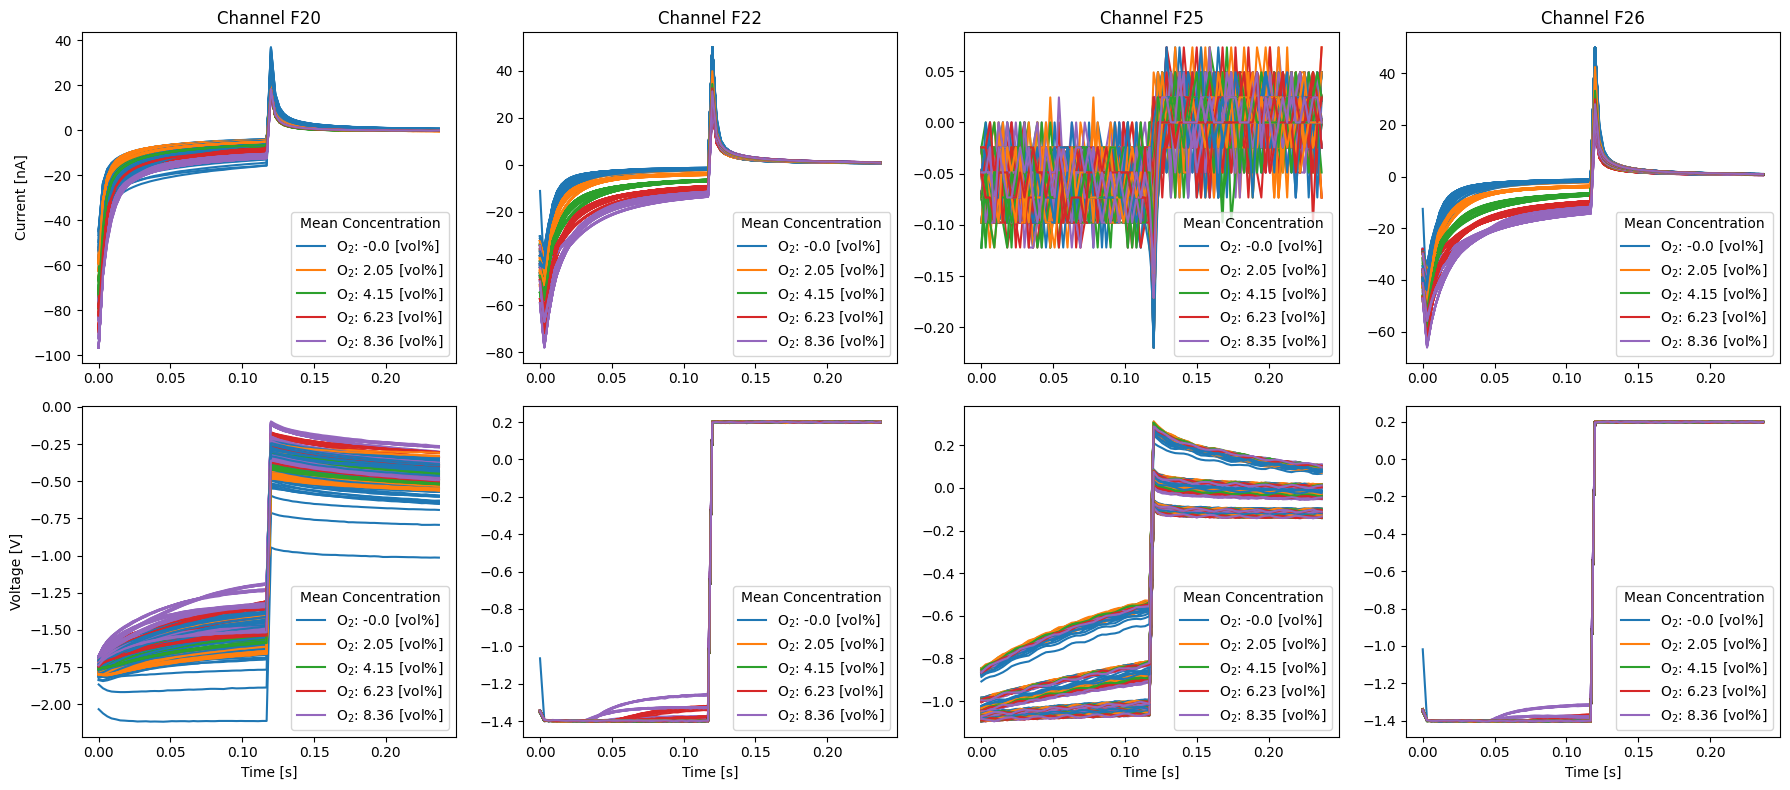

In [6]:
# Plot all I(t) measurements across all channels/sensors for all concentrations

fig0, ax0 = plt.subplots(nrows=2, ncols=4, figsize=(18, 8))
for i in range(4):
    one_sensor = current_data[(current_data["ChNum"] == sensors[i])].copy()
    one_sensor_groups = one_sensor.groupby(["SweepNum", "MeasureNum", "ConcNum"])
    osm = one_sensor.groupby(["ConcNum"])["OxygenC"].agg("mean").reset_index()

    selected_concs = set()
    for _, group in one_sensor_groups:
        conc_num = group["ConcNum"].unique()[0]
        col = category_colors[conc_num]
        conc_lbl = osm[osm["ConcNum"]==conc_num]["OxygenC"].values[0]
        label = f"O$_2$: {round(conc_lbl, 2)} [vol%]"

        if conc_num not in selected_concs:
            ax0[0, i].plot(group["Time"], group["Current"], c=col, label=label)
            ax0[1, i].plot(group["Time"], group["Voltage"], c=col, label=label)
        else:
            ax0[0, i].plot(group["Time"], group["Current"], c=col)
            ax0[1, i].plot(group["Time"], group["Voltage"], c=col)

        selected_concs.add(conc_num)
        ax0[1, i].set_xlabel("Time [s]")

    ax0[0, i].set_title(f"Channel {sensors[i]}")

    ax0[0, i].legend(title="Mean Concentration", loc="lower right")
    ax0[1, i].legend(title="Mean Concentration", loc="lower right")

ax0[0, 0].set_ylabel("Current [nA]")
ax0[1, 0].set_ylabel("Voltage [V]")

fig0.tight_layout()

TASK 3. Identify and visualize any apparent dependencies in the data.

The figure below shows three graphs:

1. I(t) vs. Oxygen concentration
2. I(t) vs. Relative humidity for all measured oxygen concentrations
3. I(t) vs. Temperature for all measured oxygen concentrations
Oxygen concentrations are represented by different colors.

I(t) exhibits a linear dependency on oxygen concentration, particularly for channels F22 and F26. 
For Channel F20, the I(t) vs. Oxygen concentration curve approximates linearity but is affected by the unstable applied voltage. 
Channel F25 shows a dependency on oxygen concentration as well. 
However, for channels F22 and F26, I(t) does not display any significant dependence on relative humidity or temperature.

TASK 4. Detect and flag any corrupted sensors.

Based on the analysis from TASK 1, Channel 25 is identified as the corrupted sensor/channel.

In [7]:
# Select the area for computing the mean Current, whcih is used as a descriptive parameter
t1 = 0.09
t2 = 0.11

current_data = current_data[(current_data["Time"] > t1) & (current_data["Time"] < t2)]

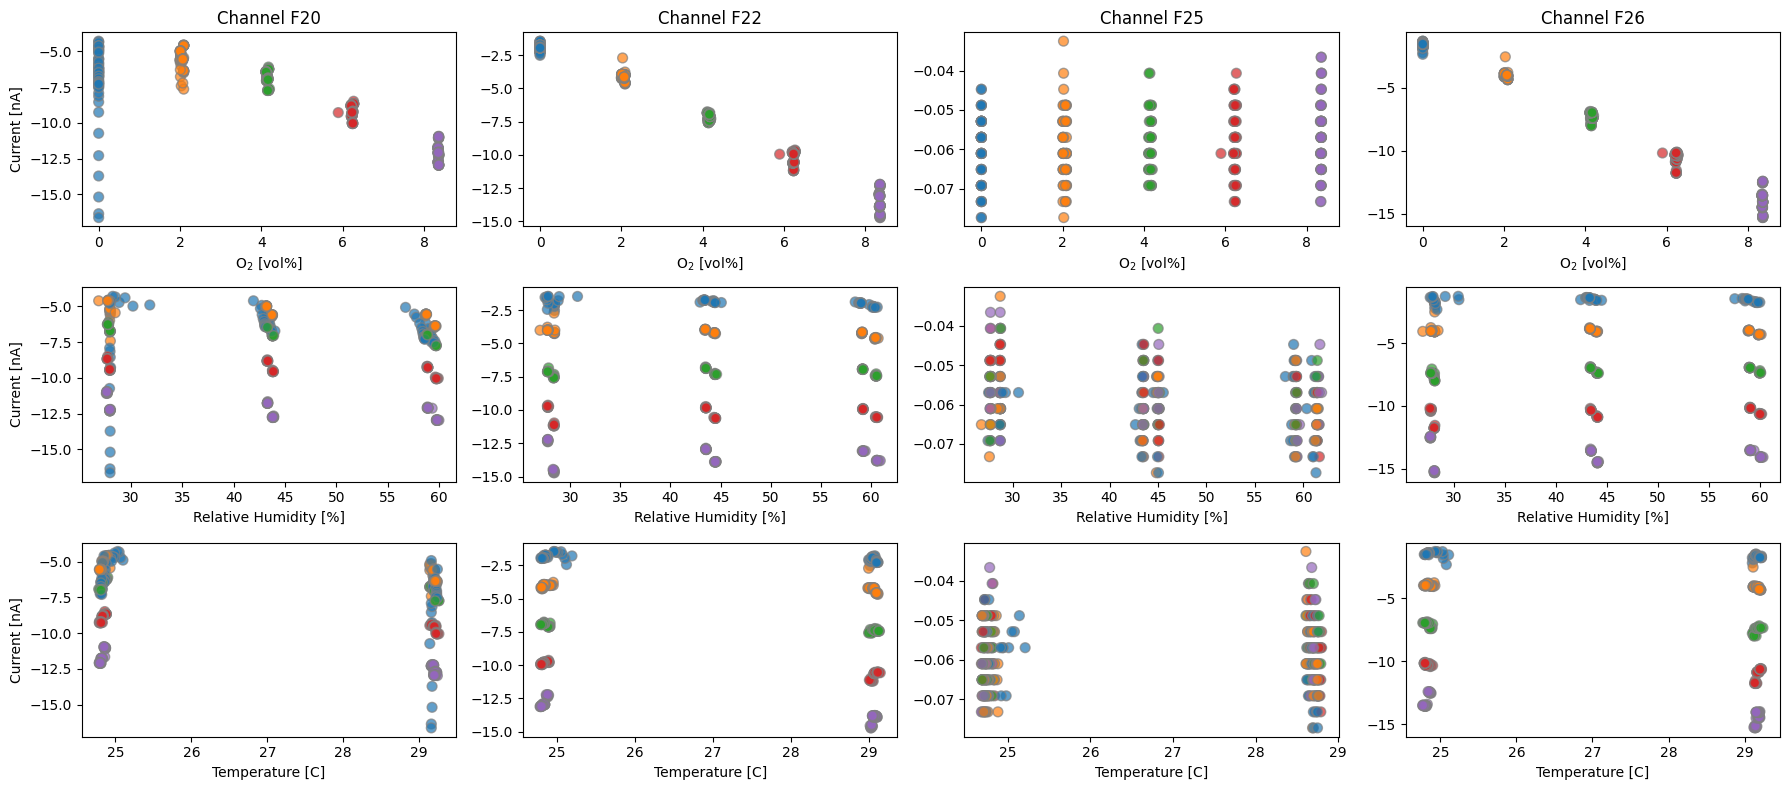

In [8]:
# Plot I vs Oxygen conc., I vs Relative humidity and I vs Temperature for all sensors for all measurements. Color of the markers indicates the Oxygen concentration.

fig1, ax1 = plt.subplots(nrows=3, ncols=4, figsize=(18, 8))
for i in range(4):
    one_sensor = current_data[(current_data["ChNum"] == sensors[i])].copy()
    one_sensor_mean = one_sensor.groupby(["SweepNum", "MeasureNum", "ConcNum"])[["Current", "OxygenC", "t_sht", "h_sht"]].mean().reset_index()
    one_sensor_mean["Color"] = one_sensor_mean["ConcNum"].map(category_colors)

    ax1[0, i].scatter(one_sensor_mean["OxygenC"], one_sensor_mean["Current"],
                   c=one_sensor_mean["Color"], s=50, edgecolors="gray", alpha=0.7)
    ax1[0, i].set_xlabel("O$_2$ [vol%]")

    ax1[1, i].scatter(one_sensor_mean["h_sht"], one_sensor_mean["Current"],
                   c=one_sensor_mean["Color"], s=50, edgecolors="gray", alpha=0.7)
    ax1[1, i].set_xlabel("Relative Humidity [%]")

    ax1[2, i].scatter(one_sensor_mean["t_sht"], one_sensor_mean["Current"],
                   c=one_sensor_mean["Color"], s=50, edgecolors="gray", alpha=0.7)
    ax1[2, i].set_xlabel("Temperature [C]")

    ax1[0, i].set_title(f"Channel {sensors[i]}")

ax1[0, 0].set_ylabel("Current [nA]")
ax1[1, 0].set_ylabel("Current [nA]")
ax1[2, 0].set_ylabel("Current [nA]")
fig1.tight_layout()


TASK 5. Attempt to calibrate the functional sensors and evaluate the oxygen level
 calibration quality using metrics such as MAE, RMSE, R2, etc.

The calibration is performed assuming the relationship:

I = m_coef * OxygenConcentratio + m_inter

The fitting and parameter extraction are carried out using a Linear Regression model.

The figure below shows calibration curves for all channels, along with the computed parameters. 
The R2 values indicate the calibration quality. Channels F22 and F26, with R2 scores of 0.98, show near-perfect calibration. 
In contrast, F20 has an R2 score of 0.55, and the corrupted Channel 25 has a very low R2 score of 0.02.

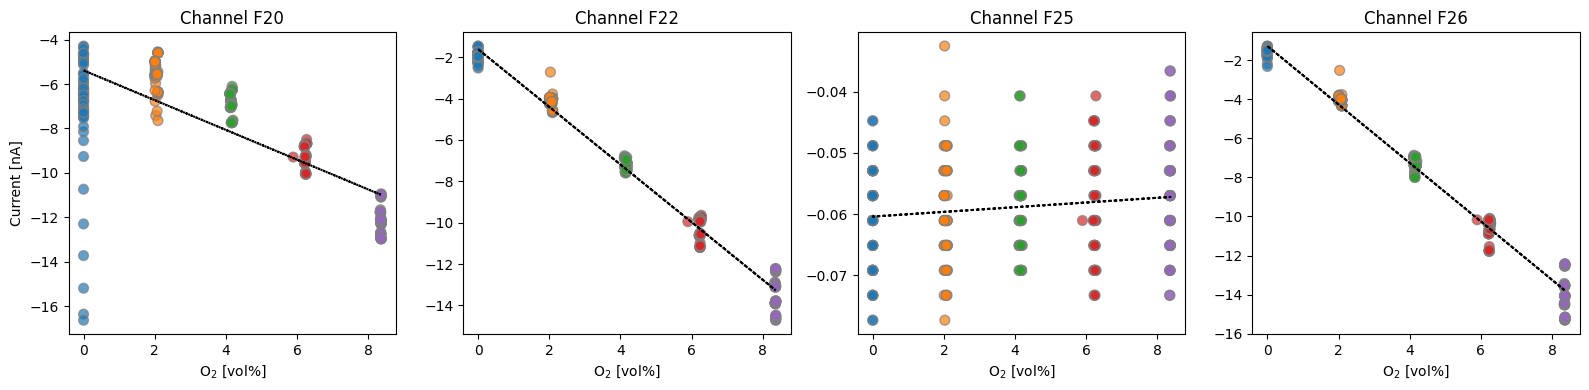

In [9]:
# Sensor calibration using Linear Regression 

calib_data = []

fig2, ax2 = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))
for i in range(4):
    one_sensor = current_data[(current_data["ChNum"] == sensors[i])].copy()
    one_sensor_mean = one_sensor.groupby(["SweepNum", "MeasureNum", "ConcNum"])[["Current", "OxygenC", "t_sht", "h_sht"]].mean().reset_index()
    one_sensor_mean["Color"] = one_sensor_mean["ConcNum"].map(category_colors)

    # Linear Regression part
    x = one_sensor_mean["OxygenC"].values.reshape(-1, 1)
    y = one_sensor_mean["Current"].values.reshape(-1, 1)
    cd = fit_data(x, y) 
    y_ = cd["y_pred"]
    cd.pop("y_pred", None)
    calib_data.append(cd)

    ax2[i].scatter(one_sensor_mean["OxygenC"], one_sensor_mean["Current"],
                   c=one_sensor_mean["Color"], s=50, edgecolors="gray", alpha=0.7)
    ax2[i].set_xlabel("O$_2$ [vol%]")

    ax2[i].plot(x, y_ , c="black", linestyle=":")

    ax2[i].set_title(f"Channel {sensors[i]}")

ax2[0].set_ylabel("Current [nA]")

fig2.tight_layout()

In [10]:
# Print the calibration parameters and metrics

calib_data = pd.DataFrame(calib_data)
print(calib_data)

    m_inter    m_coef       MAE       MSE      RMSE        R2
0 -5.385450 -0.669693  1.222481  3.175839  1.782088  0.552217
1 -1.613272 -1.394160  0.413812  0.258711  0.508637  0.984987
2 -0.060389  0.000383  0.006698  0.000067  0.008189  0.018748
3 -1.281987 -1.495243  0.406976  0.290987  0.539432  0.985314


TASK 6. Considering the intentional addition of moisture to the supplied gas, please
 describe its potential impact on the absolute values of oxygen concentration,
 effect on calibration, and how it can be accounted for.
 
Intentional addition of moisture may affect relative humidity. 
Depending on the effect, the calibration procedure might need to include relative humidity as a factor.